# Spectrum simulation for CTA

A quick example how to simulate and fit a spectrum for the [Cherenkov Telescope Array (CTA)](https://www.cta-observatory.org).

We will use the following classes:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.scripts.CTAIrf](http://docs.gammapy.org/dev/api/gammapy.scripts.CTAIrf.html)

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw
from gammapy.irf import CTAIrf

## Simulation

In [3]:
# Define simulation parameters parameters
livetime = 1 * u.h
offset = 0.5 * u.deg
# Energy from 0.1 to 100 TeV with 10 bins/decade
energy = np.logspace(-1, 2, 31) * u.TeV

In [4]:
# Define spectral model
model = PowerLaw(
    index=2.1,
    amplitude=2.5e-12 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.TeV,
)

In [5]:
# Load IRFs
filename = '$GAMMAPY_EXTRA/datasets/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits'
cta_irf = CTAIrf.read(filename)

NDDataArray summary info
energy         : size =    42, min =  0.014 TeV, max = 177.828 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



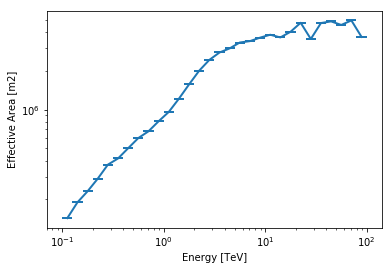

In [6]:
aeff = cta_irf.aeff.to_effective_area_table(
    offset=offset,
    energy=energy,
)
aeff.plot()
plt.loglog()
print(cta_irf.aeff.data)

NDDataArray summary info
e_true         : size =    30, min =  0.112 TeV, max = 89.125 TeV
e_reco         : size =    30, min =  0.112 TeV, max = 89.125 TeV
Data           : size =   900, min =  0.000, max =  0.926



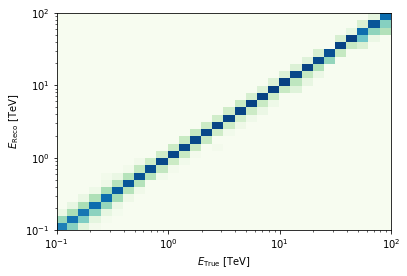

In [7]:
edisp = cta_irf.edisp.to_energy_dispersion(
    offset=offset,
    e_true=energy,
    e_reco=energy,
)
edisp.plot_matrix()
print(edisp.data)

In [8]:
# Simulate data
sim = SpectrumSimulation(aeff=aeff, edisp=edisp, source_model=model, livetime=livetime)
sim.simulate_obs(seed=42, obs_id=0)

*** Observation summary report ***
Observation Id: 0
Livetime: 1.000 h
On events: 411
Off events: 0
Alpha: 1.000
Bkg events in On region: 0.00
Excess: 411.00
Excess / Background: inf
Gamma rate: 411.00 1 / h
Bkg rate: 0.00 1 / min
Sigma: nan
energy range: 0.10 TeV - 100.00 TeV


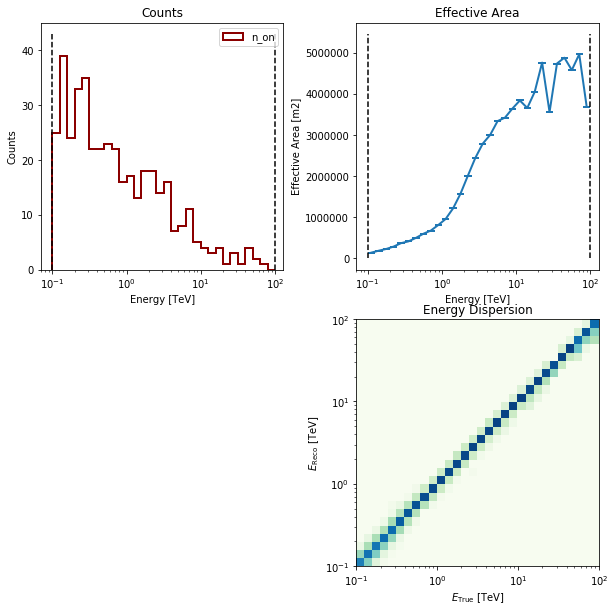

In [9]:
sim.obs.peek()
print(sim.obs)

## Spectral analysis

Now that we have some simulated CTA counts spectrum, let's analyse it.

In [10]:
# Fit data
fit = SpectrumFit(obs_list=sim.obs, model=model, stat='cash')
fit.run()
result = fit.result[0]

FCN = -1591.3965360289785 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 5.608110517101211e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_index,2.11579,0.0344627,0,0,,,
2,par_001_amplitude,0.23819,0.012046,0,0,,,
3,par_002_reference,1,1,0,0,0.0,,FIXED


In [11]:
print(result)


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.116e+00 3.446e-02                       nan nan
	amplitude 2.382e-12 1.205e-13 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name           index                amplitude        reference
	--------- ---------------------- ---------------------- ---------
	    index  0.0011876796266677978 -9.160316528959562e-16       0.0
	amplitude -9.160316528959562e-16 1.4510495859157793e-26       0.0
	reference                    0.0                    0.0       0.0 

Statistic: -1591.397 (cash)
Fit Range: [  0.1 100. ] TeV



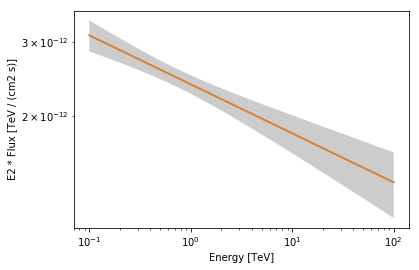

In [12]:
energy_range = [0.1, 100] * u.TeV
model.plot(energy_range=energy_range, energy_power=2)
result.model.plot(energy_range=energy_range, energy_power=2)
result.model.plot_error(energy_range=energy_range, energy_power=2);

## Exercises

* Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
* Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0

In [13]:
# Start the exercises here!

## What next?

In this tutorial we simulated and analysed the spectrum of source using CTA prod 2 IRFs.

If you'd like to go further, please see the other tutorial notebooks.